# Somatostatin (Sst) Interneuron Receptor Expression Across Isocortex (MERFISH)

This notebook examines neuromodulator receptor expression in **Sst GABAergic interneurons**
across all isocortical areas using MERFISH spatial transcriptomics from the Allen Brain Cell Atlas.

### Motivation
Sst interneurons are a major class of cortical inhibitory neurons that provide dendritic
inhibition to pyramidal cells. A key question is whether their receptor expression is
**cell-type-intrinsic** (same everywhere) or **region-specific** (tuned to local circuits).

### Approach
- Filter all MERFISH cells to Sst Gaba subclass
- Group by isocortical parcellation structure (PL, ILA, ACAd, MOp, SSp-bfd, VISp, etc.)
- Compare receptor profiles across ~30+ cortical areas
- Also examine Sst supertypes across regions

### MERFISH Gene Panel (11 receptors)
- **Serotonin (5)**: Htr1b, Htr1d, Htr2a, Htr3a, Htr7
- **Norepinephrine (2)**: Adra1a, Adra1b
- **Dopamine (4)**: Drd1, Drd2, Drd3, Drd5

In [1]:
import pandas as pd
import numpy as np
import re
import os
import anndata
import scanpy as sc
import matplotlib.pyplot as plt
from pathlib import Path

from abc_atlas_access.abc_atlas_cache.abc_project_cache import AbcProjectCache

## 1. Initialize Cache and Load Metadata

In [2]:
download_base = Path('../../data/abc_atlas')
abc_cache = AbcProjectCache.from_s3_cache(download_base)
print(f'Manifest: {abc_cache.current_manifest}')

Manifest: releases/20251031/manifest.json


/home/user/abc_atlas_access/src/abc_atlas_access/abc_atlas_cache/cloud_cache.py:679: OutdatedManifestWarning: You are loading releases/20251031/manifest.json. A more up to date version of the dataset -- releases/20260131/manifest.json -- exists online. To see the changes between the two versions of the dataset, run
type.compare_manifests('releases/20251031/manifest.json', 'releases/20260131/manifest.json')
To load another version of the dataset, run
type.load_manifest('releases/20260131/manifest.json')
  warnings.warn(msg, OutdatedManifestWarning)


In [3]:
ccf_meta = abc_cache.get_metadata_dataframe(
    directory='MERFISH-C57BL6J-638850-CCF',
    file_name='cell_metadata_with_parcellation_annotation',
    dtype={'cell_label': str}
)
ccf_meta.set_index('cell_label', inplace=True)
print(f'Total MERFISH cells with CCF: {len(ccf_meta):,}')

Total MERFISH cells with CCF: 3,739,961


## 2. Identify All Sst Interneurons in Isocortex

Filter to Sst Gaba subclass, then restrict to isocortical parcellation structures.

In [4]:
# Filter to Sst Gaba subclass
sst_mask = ccf_meta['subclass'].str.contains('Sst Gaba', na=False) & ~ccf_meta['subclass'].str.contains('Chodl', na=False)
sst_all = ccf_meta[sst_mask].copy()
print(f'Total Sst Gaba cells (all brain): {len(sst_all):,}')

# Also get Sst Chodl separately
chodl_mask = ccf_meta['subclass'].str.contains('Sst Chodl', na=False)
chodl_all = ccf_meta[chodl_mask].copy()
print(f'Total Sst Chodl Gaba cells (all brain): {len(chodl_all):,}')

# Show parcellation_division to find isocortex
print(f"\nSst cells by parcellation_division:")
for div, cnt in sst_all.groupby('parcellation_division', observed=True).size().sort_values(ascending=False).head(10).items():
    print(f'  {div}: {cnt:,}')

Total Sst Gaba cells (all brain): 36,360


Total Sst Chodl Gaba cells (all brain): 4,376

Sst cells by parcellation_division:
  Isocortex: 23,717
  HPF: 6,693
  OLF: 2,288
  CTXsp: 1,942
  lfbs: 458
  mfbs: 430
  STR: 418
  scwm: 120
  VL: 110
  brain-unassigned: 61


In [5]:
# Filter to isocortex
iso_sst = sst_all[sst_all['parcellation_division'] == 'Isocortex'].copy()
iso_chodl = chodl_all[chodl_all['parcellation_division'] == 'Isocortex'].copy()
print(f'Isocortex Sst Gaba: {len(iso_sst):,}')
print(f'Isocortex Sst Chodl: {len(iso_chodl):,}')

# Combine Sst + Sst Chodl
iso_sst_combined = pd.concat([iso_sst, iso_chodl])
print(f'Total Sst (incl Chodl): {len(iso_sst_combined):,}')

# Show all cortical areas with Sst cells
area_counts = iso_sst_combined.groupby('parcellation_structure', observed=True).size().sort_values(ascending=False)
print(f'\nCortical areas with Sst cells: {len(area_counts)}')
print(f'\nAll areas (>= 20 cells):')
for area, cnt in area_counts.items():
    if cnt >= 20:
        print(f'  {area:12s}: {cnt:>5,} Sst cells')

Isocortex Sst Gaba: 23,717
Isocortex Sst Chodl: 826
Total Sst (incl Chodl): 24,543

Cortical areas with Sst cells: 43

All areas (>= 20 cells):
  MOs         : 2,501 Sst cells
  MOp         : 2,314 Sst cells
  SSs         : 1,886 Sst cells
  VISp        : 1,485 Sst cells
  SSp-m       : 1,369 Sst cells
  SSp-bfd     : 1,296 Sst cells
  RSPv        :   797 Sst cells
  TEa         :   779 Sst cells
  SSp-ul      :   722 Sst cells
  ACAv        :   712 Sst cells
  AId         :   633 Sst cells
  PL          :   605 Sst cells
  ACAd        :   602 Sst cells
  ORBl        :   597 Sst cells
  RSPd        :   581 Sst cells
  SSp-n       :   542 Sst cells
  SSp-ll      :   505 Sst cells
  RSPagl      :   450 Sst cells
  ORBvl       :   428 Sst cells
  VISC        :   417 Sst cells
  AUDv        :   416 Sst cells
  AUDp        :   383 Sst cells
  GU          :   371 Sst cells
  VISa        :   355 Sst cells
  ORBm        :   324 Sst cells
  VISl        :   309 Sst cells
  AIp         :   307 Ss

In [6]:
# Select areas with >= 50 Sst cells for robust estimates
min_cells = 50
valid_areas = area_counts[area_counts >= min_cells].index.tolist()
iso_sst_selected = iso_sst_combined[iso_sst_combined['parcellation_structure'].isin(valid_areas)].copy()
print(f'Selected: {len(valid_areas)} cortical areas, {len(iso_sst_selected):,} Sst cells')

# Group areas by functional category for ordering
area_categories = {
    # Prefrontal / Cingulate
    'PL': 'Prefrontal', 'ILA': 'Prefrontal', 'ACAd': 'Cingulate', 'ACAv': 'Cingulate',
    'ORBl': 'Orbital', 'ORBm': 'Orbital', 'ORBvl': 'Orbital',
    # Motor
    'MOp': 'Motor', 'MOs': 'Motor',
    # Somatosensory
    'SSp-bfd': 'Somatosensory', 'SSp-ll': 'Somatosensory', 'SSp-m': 'Somatosensory',
    'SSp-n': 'Somatosensory', 'SSp-tr': 'Somatosensory', 'SSp-ul': 'Somatosensory',
    'SSp-un': 'Somatosensory', 'SSs': 'Somatosensory',
    # Visual
    'VISp': 'Visual', 'VISl': 'Visual', 'VISpm': 'Visual', 'VISam': 'Visual',
    'VISrl': 'Visual', 'VISal': 'Visual', 'VISa': 'Visual', 'VISli': 'Visual',
    # Auditory
    'AUDp': 'Auditory', 'AUDd': 'Auditory', 'AUDv': 'Auditory', 'AUDpo': 'Auditory',
    # Retrosplenial
    'RSPd': 'Retrosplenial', 'RSPv': 'Retrosplenial', 'RSPagl': 'Retrosplenial',
    # Temporal / Insular / Other
    'TEa': 'Temporal', 'ECT': 'Temporal', 'PERI': 'Temporal',
    'AI': 'Insular', 'GU': 'Insular', 'VISC': 'Insular',
    'PTLp': 'Parietal',
}

# Assign category
iso_sst_selected['area_category'] = iso_sst_selected['parcellation_structure'].map(area_categories).fillna('Other')

# Order: prefrontal -> cingulate -> motor -> somatosensory -> visual -> auditory -> retrosplenial -> temporal -> insular
cat_order = ['Prefrontal', 'Cingulate', 'Orbital', 'Motor', 'Somatosensory', 'Visual',
             'Auditory', 'Retrosplenial', 'Parietal', 'Temporal', 'Insular', 'Other']

# Sort areas by category then name
area_cat_map = {a: area_categories.get(a, 'Other') for a in valid_areas}
sorted_areas = sorted(valid_areas, key=lambda a: (cat_order.index(area_cat_map[a]) if area_cat_map[a] in cat_order else 99, a))

print(f'\nAreas ordered by functional group:')
for area in sorted_areas:
    cat = area_cat_map[area]
    n = area_counts[area]
    print(f'  [{cat:15s}] {area:12s}: {n:>5,} cells')

Selected: 43 cortical areas, 24,543 Sst cells

Areas ordered by functional group:
  [Prefrontal     ] ILA         :   229 cells
  [Prefrontal     ] PL          :   605 cells
  [Cingulate      ] ACAd        :   602 cells
  [Cingulate      ] ACAv        :   712 cells
  [Orbital        ] ORBl        :   597 cells
  [Orbital        ] ORBm        :   324 cells
  [Orbital        ] ORBvl       :   428 cells
  [Motor          ] MOp         : 2,314 cells
  [Motor          ] MOs         : 2,501 cells
  [Somatosensory  ] SSp-bfd     : 1,296 cells
  [Somatosensory  ] SSp-ll      :   505 cells
  [Somatosensory  ] SSp-m       : 1,369 cells
  [Somatosensory  ] SSp-n       :   542 cells
  [Somatosensory  ] SSp-tr      :   237 cells
  [Somatosensory  ] SSp-ul      :   722 cells
  [Somatosensory  ] SSp-un      :   235 cells
  [Somatosensory  ] SSs         : 1,886 cells
  [Visual         ] VISa        :   355 cells
  [Visual         ] VISal       :   108 cells
  [Visual         ] VISam       :   217 cell

## 3. Load Receptor Gene Metadata

In [7]:
gene = abc_cache.get_metadata_dataframe(directory='MERFISH-C57BL6J-638850', file_name='gene')
gene.set_index('gene_identifier', inplace=True)

serotonin_receptors = ['Htr1b', 'Htr1d', 'Htr2a', 'Htr3a', 'Htr7']
norepinephrine_receptors = ['Adra1a', 'Adra1b']
dopamine_receptors = ['Drd1', 'Drd2', 'Drd3', 'Drd5']
all_receptors = serotonin_receptors + norepinephrine_receptors + dopamine_receptors

available_genes = gene[gene['gene_symbol'].isin(all_receptors)]
receptor_genes = [g for g in all_receptors if g in set(available_genes['gene_symbol'])]
gene_ensembl_ids = available_genes.index.tolist()
print(f'Receptor genes in MERFISH: {len(receptor_genes)} — {receptor_genes}')

Receptor genes in MERFISH: 11 — ['Htr1b', 'Htr1d', 'Htr2a', 'Htr3a', 'Htr7', 'Adra1a', 'Adra1b', 'Drd1', 'Drd2', 'Drd3', 'Drd5']


## 4. Extract Expression Data

In [8]:
csv_expr = 'sst_isocortex_merfish_expression.csv'
csv_meta = 'sst_isocortex_merfish_metadata.csv'

if os.path.exists(csv_expr):
    expression_data = pd.read_csv(csv_expr, index_col=0)
    print(f'Loaded from {csv_expr}: {expression_data.shape[0]:,} cells x {expression_data.shape[1]} genes')
else:
    file_path = abc_cache.get_file_path(
        directory='MERFISH-C57BL6J-638850',
        file_name='C57BL6J-638850/log2'
    )
    print(f'Loading MERFISH expression: {os.path.getsize(file_path) / 1e9:.1f} GB')
    
    adata = anndata.read_h5ad(file_path, backed='r')
    print(f'Matrix: {adata.shape[0]:,} cells x {adata.shape[1]} genes')
    
    gene_mask = adata.var.index.isin(gene_ensembl_ids)
    cell_mask = adata.obs.index.isin(iso_sst_selected.index)
    cell_idx = np.where(cell_mask)[0]
    gene_idx = np.where(gene_mask)[0]
    
    print(f'Sst cells found: {len(cell_idx):,}')
    print(f'Receptor genes found: {len(gene_idx)}')
    
    subset = adata[cell_idx, gene_idx].to_memory()
    gene_filtered = adata.var[gene_mask]
    expression_data = subset.to_df()
    expression_data.columns = gene_filtered['gene_symbol'].values
    expression_data = expression_data[receptor_genes]
    
    adata.file.close()
    del adata
    
    expression_data.to_csv(csv_expr)
    print(f'Saved to {csv_expr}')

# Save metadata
meta_cols = ['subclass', 'supertype', 'class', 'neurotransmitter',
             'parcellation_structure', 'parcellation_substructure']
iso_sst_selected.loc[expression_data.index, meta_cols].to_csv(csv_meta)
print(f'\nExtracted: {expression_data.shape[0]:,} cells x {expression_data.shape[1]} genes')

Loading MERFISH expression: 7.6 GB


Matrix: 4,334,174 cells x 550 genes
Sst cells found: 24,543
Receptor genes found: 11


Saved to sst_isocortex_merfish_expression.csv

Extracted: 24,543 cells x 11 genes


## 5. Build AnnData and Dot Plot: Sst by Cortical Area

In [9]:
# Build AnnData with cortical area as grouping variable
meta = iso_sst_selected.loc[expression_data.index].copy()

adata_sst = anndata.AnnData(
    X=expression_data.values,
    obs=meta[meta_cols].copy(),
    var=pd.DataFrame(index=receptor_genes)
)

# Add area category
adata_sst.obs['area'] = adata_sst.obs['parcellation_structure'].values
adata_sst.obs['area_cat'] = adata_sst.obs['area'].map(area_categories).fillna('Other')

# Create ordered categorical for areas
adata_sst.obs['area'] = pd.Categorical(
    adata_sst.obs['area'], categories=sorted_areas, ordered=True
)

# Add area label with category prefix for visual grouping
adata_sst.obs['area_label'] = adata_sst.obs.apply(
    lambda r: f"{area_categories.get(r['parcellation_structure'], 'Other')} | {r['parcellation_structure']}",
    axis=1
)
label_order = [f"{area_categories.get(a, 'Other')} | {a}" for a in sorted_areas]
adata_sst.obs['area_label'] = pd.Categorical(
    adata_sst.obs['area_label'], categories=label_order, ordered=True
)

n_areas = len(sorted_areas)
print(f'AnnData: {adata_sst.shape[0]:,} cells x {adata_sst.shape[1]} genes')
print(f'{n_areas} cortical areas')

AnnData: 24,543 cells x 11 genes
43 cortical areas


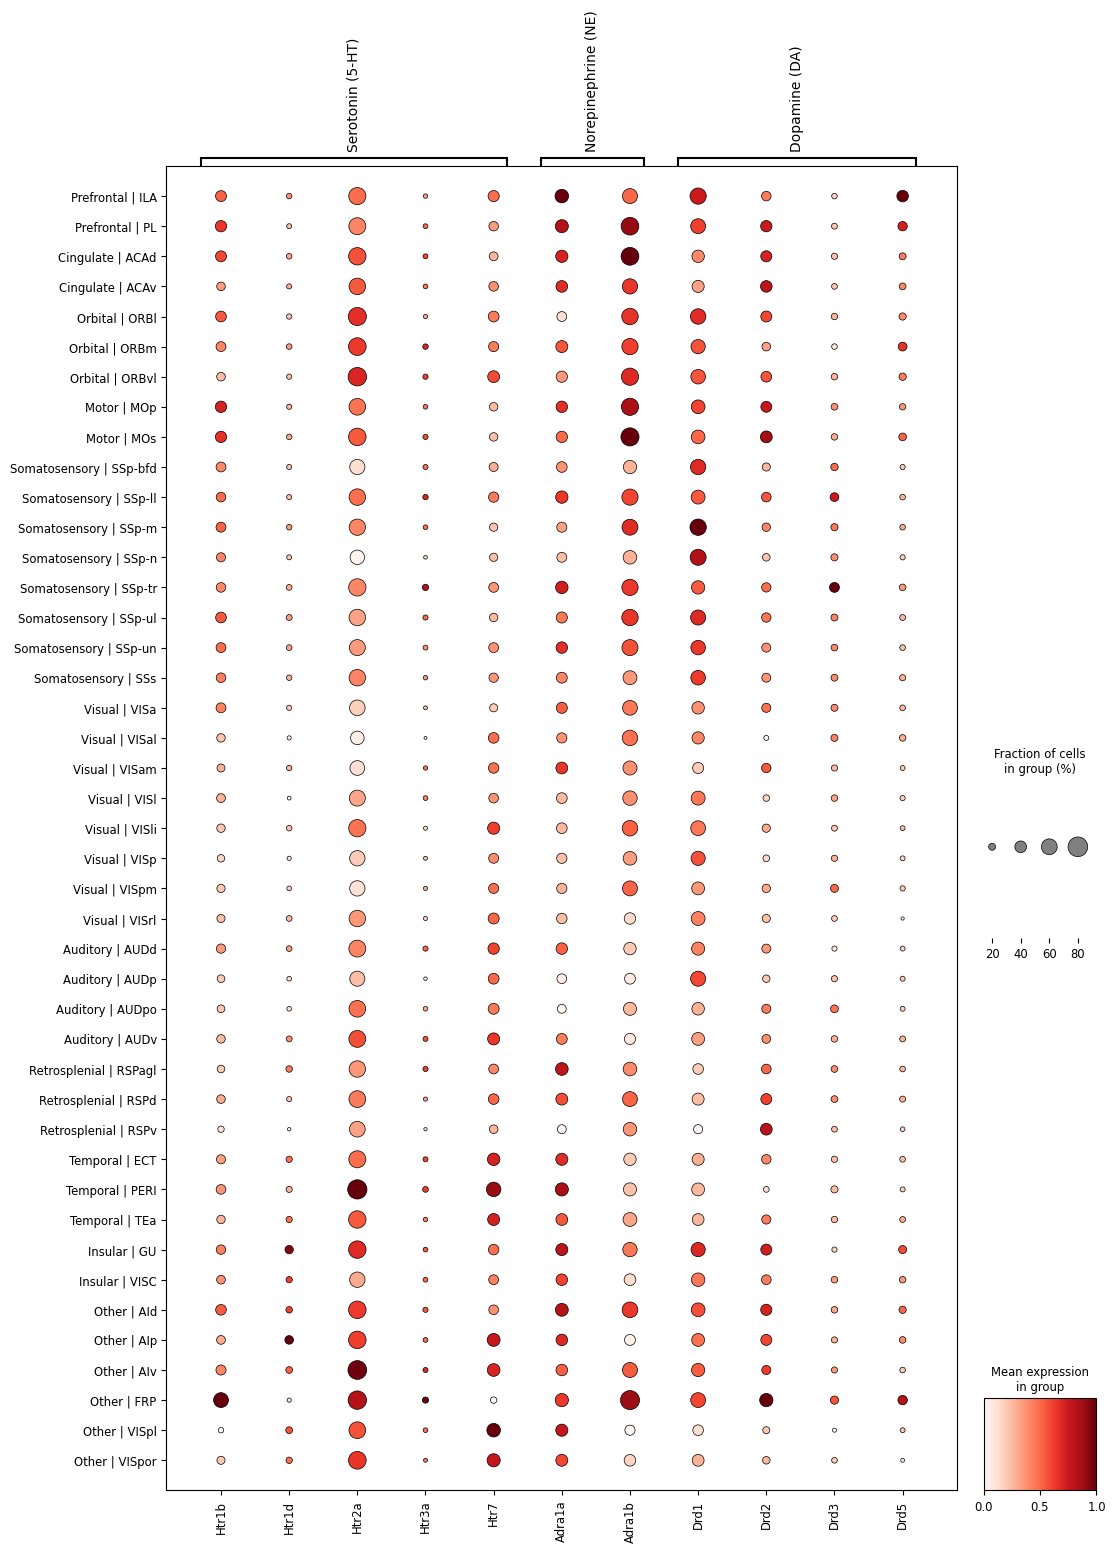

Saved: dotplot_Sst_isocortex_MERFISH_by_area.png


In [10]:
# Dot plot: Sst receptor expression by cortical area
receptor_groups = {
    'Serotonin (5-HT)': [g for g in serotonin_receptors if g in receptor_genes],
    'Norepinephrine (NE)': [g for g in norepinephrine_receptors if g in receptor_genes],
    'Dopamine (DA)': [g for g in dopamine_receptors if g in receptor_genes],
}

dp = sc.pl.dotplot(
    adata_sst,
    var_names=receptor_groups,
    groupby='area_label',
    standard_scale='var',
    cmap='Reds',
    figsize=(12, max(8, n_areas * 0.4)),
    show=False,
    return_fig=True
)
dp.style(dot_edge_color='black', dot_edge_lw=0.5)
dp.savefig('dotplot_Sst_isocortex_MERFISH_by_area.png', dpi=150, bbox_inches='tight')
plt.show()
print('Saved: dotplot_Sst_isocortex_MERFISH_by_area.png')

## 6. Dot Plot: Sst Supertypes Across Key Cortical Areas

Are there Sst supertype-specific receptor patterns that differ by region?

In [11]:
# Show supertype breakdown
adata_sst.obs['supertype_short'] = adata_sst.obs['supertype'].apply(
    lambda x: re.sub(r'^\d+\s+', '', str(x))
)

st_counts = adata_sst.obs.groupby('supertype_short', observed=True).size().sort_values(ascending=False)
print(f'Sst supertypes in isocortex ({len(st_counts)}):')
for st, cnt in st_counts.items():
    print(f'  {st}: {cnt:,} cells')

Sst supertypes in isocortex (23):
  Sst Gaba_4: 3,863 cells
  Sst Gaba_7: 3,445 cells
  Sst Gaba_10: 2,812 cells
  Sst Gaba_1: 2,787 cells
  Sst Gaba_8: 2,535 cells
  Sst Gaba_9: 1,968 cells
  Sst Gaba_16: 1,709 cells
  Sst Gaba_5: 1,183 cells
  Sst Gaba_11: 1,035 cells
  Sst Gaba_13: 927 cells
  Sst Chodl Gaba_4: 784 cells
  Sst Gaba_14: 595 cells
  Sst Gaba_12: 243 cells
  Sst Gaba_3: 233 cells
  Sst Gaba_2: 143 cells
  Sst Gaba_18: 97 cells
  Sst Gaba_15: 89 cells
  Sst Gaba_17: 33 cells
  Sst Chodl Gaba_2: 24 cells
  Sst Gaba_19: 19 cells
  Sst Chodl Gaba_5: 17 cells
  Sst Gaba_6: 1 cells
  Sst Chodl Gaba_1: 1 cells


Supertype x area combinations (>= 20 cells): 129
Total cells: 11,986


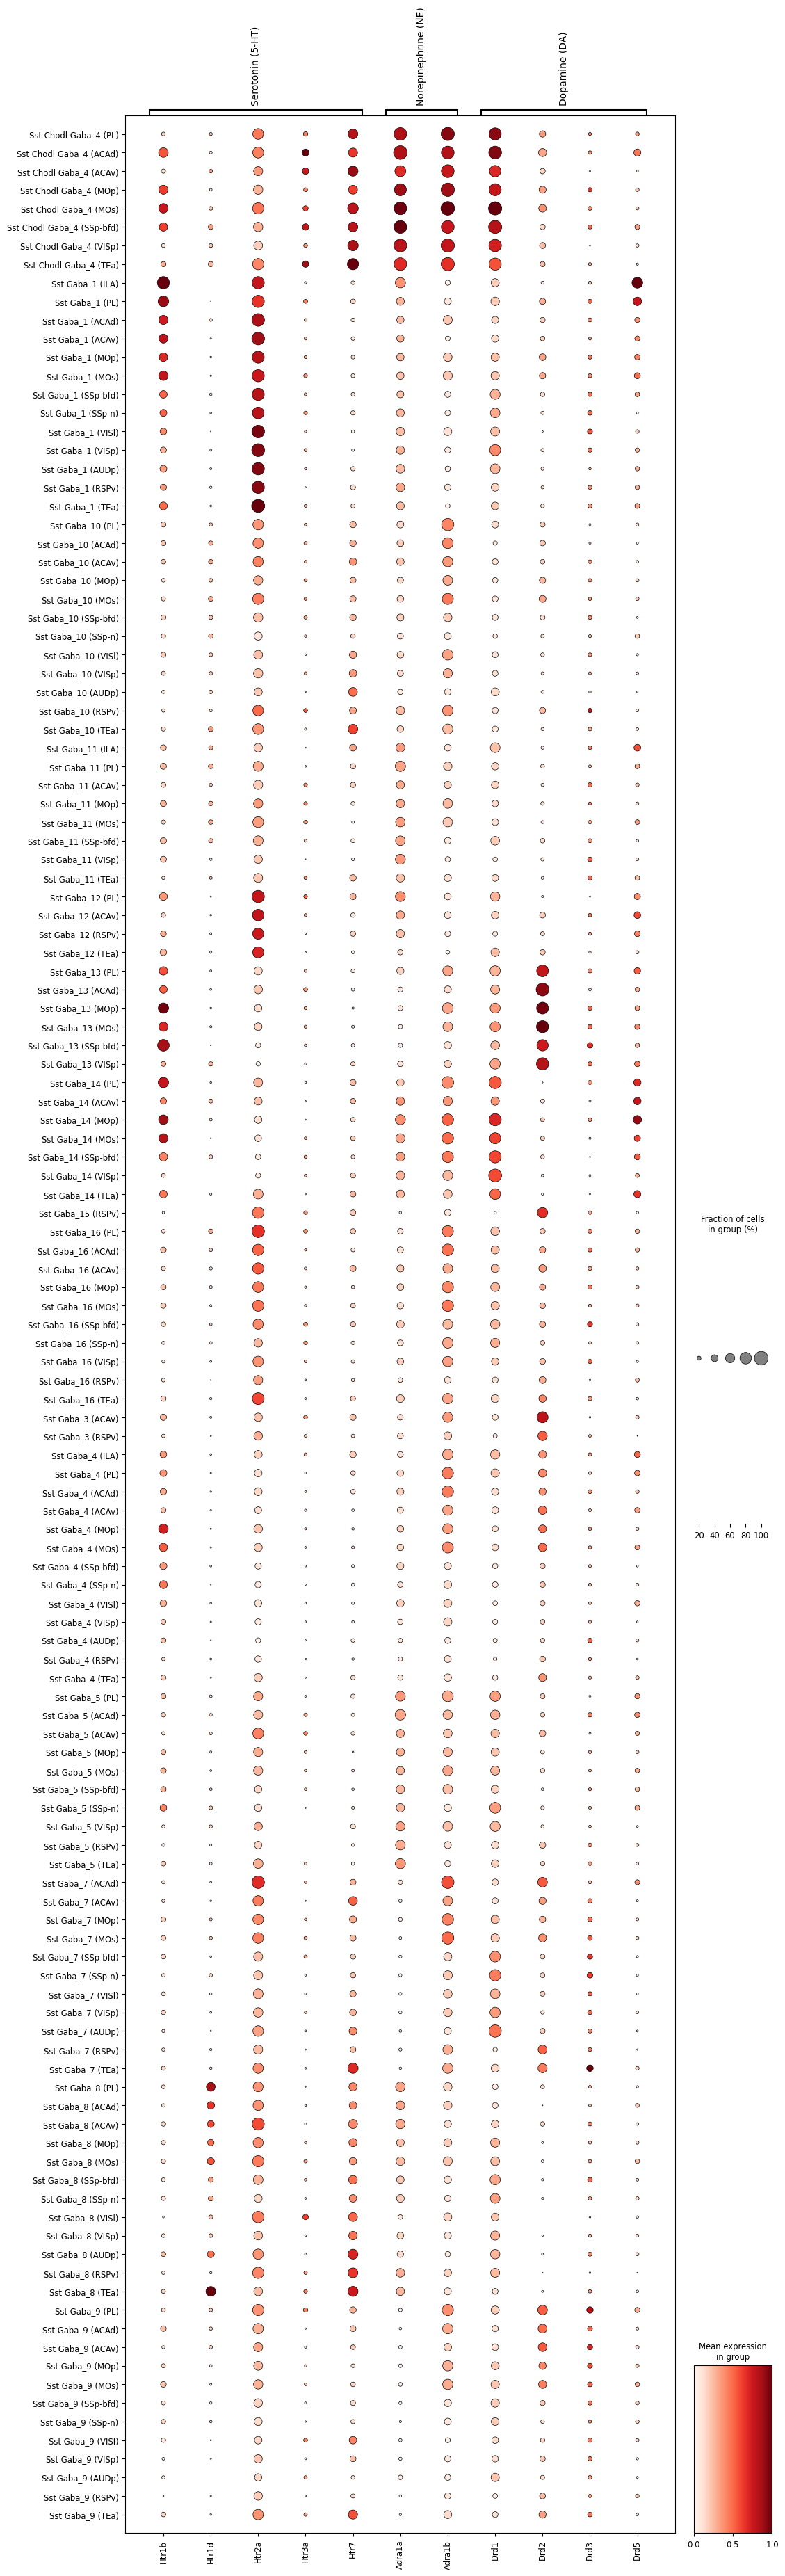

Saved: dotplot_Sst_isocortex_MERFISH_by_supertype_area.png


In [12]:
# Select key areas for supertype comparison (high cell count, diverse)
key_areas = ['PL', 'ILA', 'ACAd', 'ACAv', 'MOp', 'MOs', 'SSp-bfd', 'SSp-n',
             'VISp', 'VISl', 'AUDp', 'RSPv', 'AI', 'PTLp', 'TEa']
key_areas = [a for a in key_areas if a in valid_areas]

# Build combined label: supertype + area
adata_key = adata_sst[adata_sst.obs['area'].isin(key_areas)].copy()

# Filter to supertypes with >= 30 cells total in key areas
st_key_counts = adata_key.obs.groupby('supertype_short', observed=True).size()
valid_st = st_key_counts[st_key_counts >= 30].index.tolist()
adata_key = adata_key[adata_key.obs['supertype_short'].isin(valid_st)].copy()

# Combined label
adata_key.obs['st_area'] = (
    adata_key.obs['supertype_short'].astype(str) + ' (' +
    adata_key.obs['parcellation_structure'].astype(str) + ')'
)

# Filter combined groups to >= 20 cells
combo_counts = adata_key.obs.groupby('st_area', observed=True).size()
valid_combos = combo_counts[combo_counts >= 20].index.tolist()
adata_key = adata_key[adata_key.obs['st_area'].isin(valid_combos)].copy()

# Sort: by supertype, then by area within each supertype
def combo_sort_key(name):
    parts = name.rsplit(' (', 1)
    st = parts[0]
    area = parts[1].rstrip(')') if len(parts) > 1 else ''
    area_idx = sorted_areas.index(area) if area in sorted_areas else 999
    return (st, area_idx)

sorted_combos = sorted(valid_combos, key=combo_sort_key)
adata_key.obs['st_area'] = pd.Categorical(
    adata_key.obs['st_area'], categories=sorted_combos, ordered=True
)

n_combos = len(sorted_combos)
print(f'Supertype x area combinations (>= 20 cells): {n_combos}')
print(f'Total cells: {len(adata_key):,}')

dp2 = sc.pl.dotplot(
    adata_key,
    var_names=receptor_groups,
    groupby='st_area',
    standard_scale='var',
    cmap='Reds',
    figsize=(12, max(8, n_combos * 0.35)),
    show=False,
    return_fig=True
)
dp2.style(dot_edge_color='black', dot_edge_lw=0.5)
dp2.savefig('dotplot_Sst_isocortex_MERFISH_by_supertype_area.png', dpi=150, bbox_inches='tight')
plt.show()
print('Saved: dotplot_Sst_isocortex_MERFISH_by_supertype_area.png')

## 7. Heatmap: Regional Variation in Sst Receptor Expression

Quantify how much receptor expression varies across cortical areas for Sst neurons.

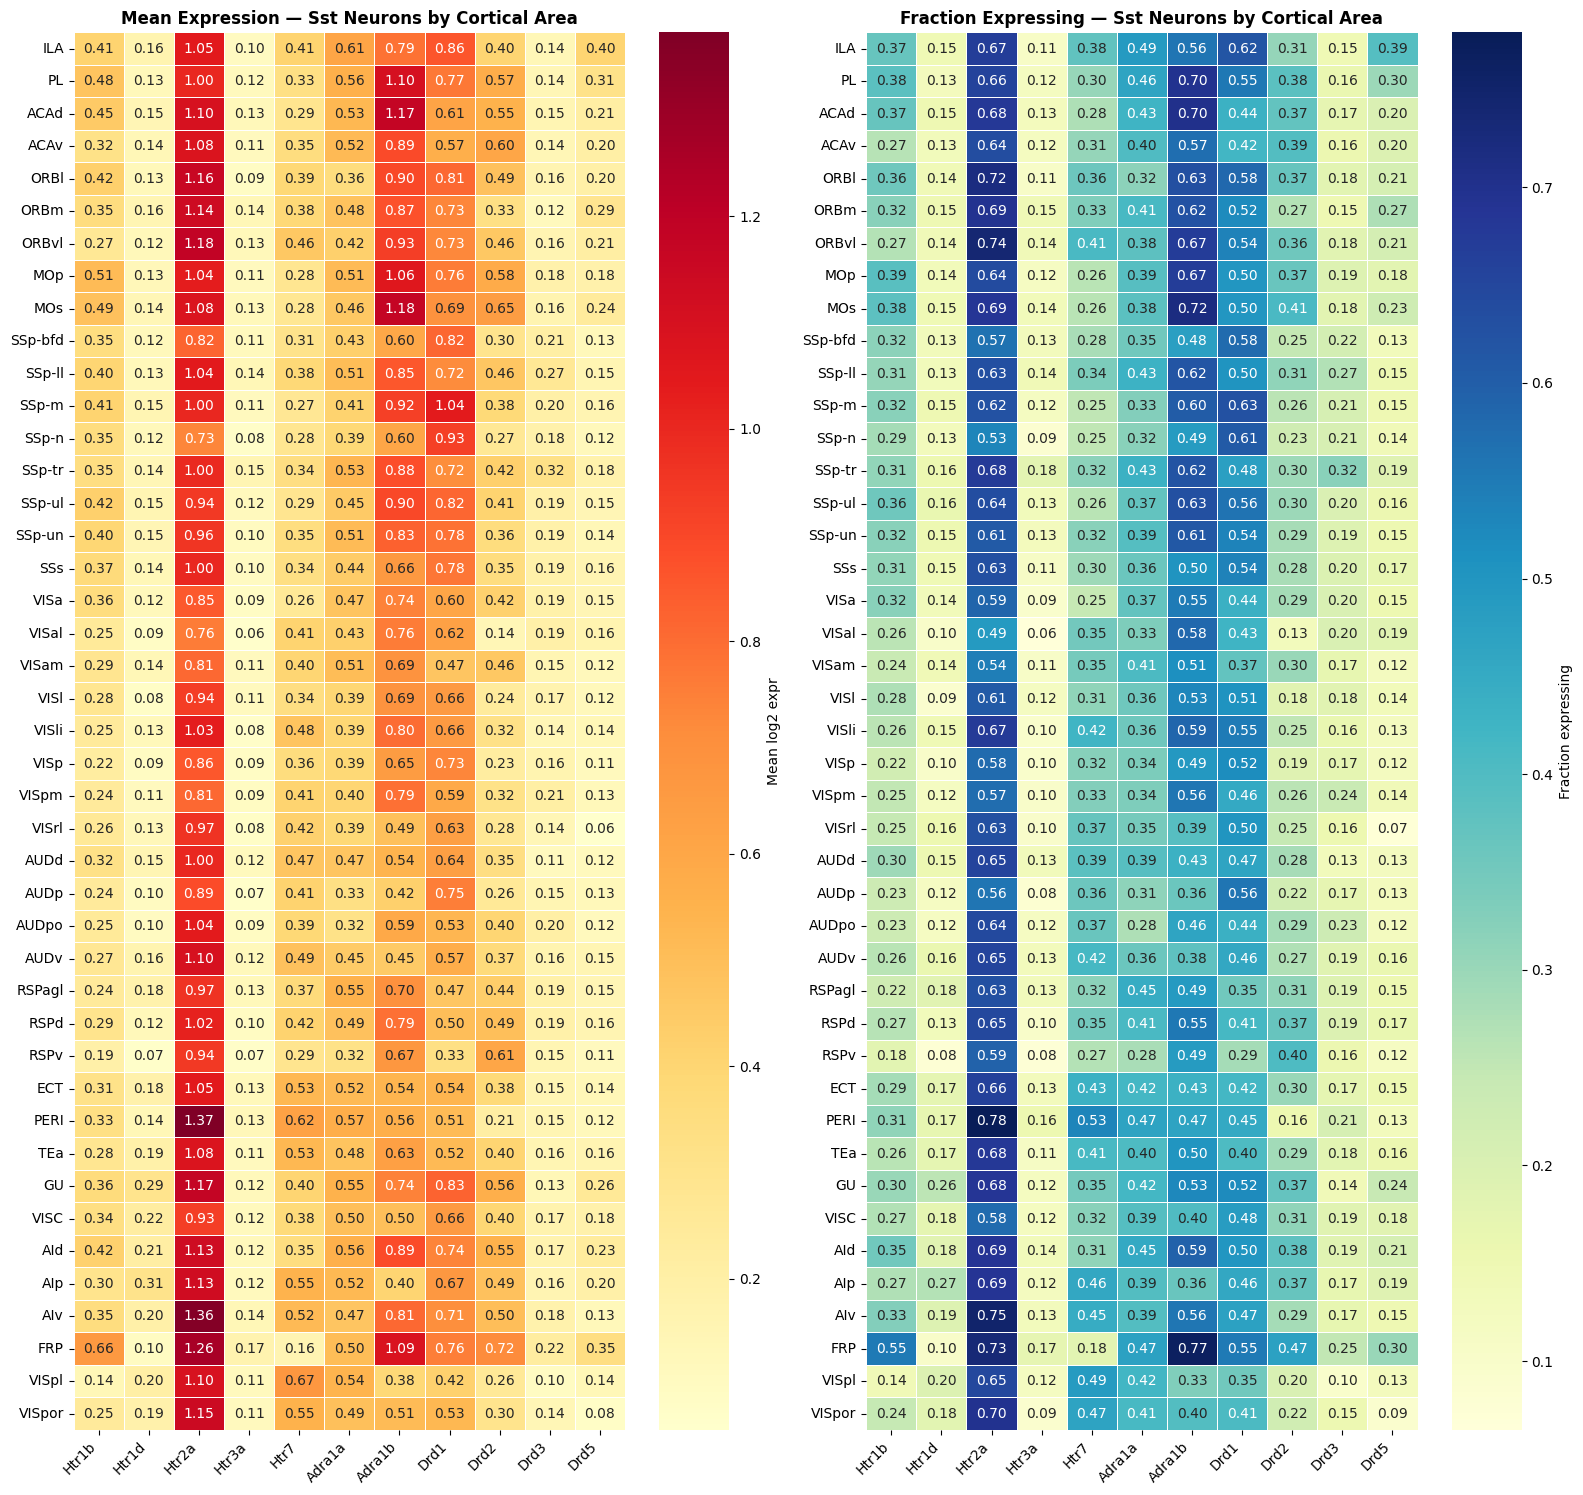

Saved: heatmap_Sst_isocortex_MERFISH.png


In [13]:
import seaborn as sns

# Compute per-area mean expression and fraction expressing
expr_df = pd.DataFrame(adata_sst.X, index=adata_sst.obs.index, columns=receptor_genes)
expr_df['area'] = adata_sst.obs['area'].values

area_mean = expr_df.groupby('area', observed=True)[receptor_genes].mean()
area_frac = expr_df.groupby('area', observed=True)[receptor_genes].apply(lambda x: (x > 0).mean())

# Reorder
area_mean = area_mean.loc[sorted_areas]
area_frac = area_frac.loc[sorted_areas]

# Heatmaps
fig, axes = plt.subplots(1, 2, figsize=(16, max(6, n_areas * 0.35)))

sns.heatmap(area_mean, annot=True, fmt='.2f', cmap='YlOrRd', ax=axes[0],
            linewidths=0.5, cbar_kws={'label': 'Mean log2 expr'})
axes[0].set_title('Mean Expression — Sst Neurons by Cortical Area', fontweight='bold')
axes[0].set_ylabel('')
axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=45, ha='right')

sns.heatmap(area_frac, annot=True, fmt='.2f', cmap='YlGnBu', ax=axes[1],
            linewidths=0.5, cbar_kws={'label': 'Fraction expressing'})
axes[1].set_title('Fraction Expressing — Sst Neurons by Cortical Area', fontweight='bold')
axes[1].set_ylabel('')
axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=45, ha='right')

plt.tight_layout()
plt.savefig('heatmap_Sst_isocortex_MERFISH.png', dpi=150, bbox_inches='tight')
plt.show()
print('Saved: heatmap_Sst_isocortex_MERFISH.png')

In [14]:
# Coefficient of variation across areas for each gene
cv_frac = area_frac.std() / area_frac.mean()
cv_mean = area_mean.std() / area_mean.mean()

print('Regional variation in Sst receptor expression (CV across cortical areas):')
print(f'\n{"Gene":>10s}  {"CV(frac)":>10s}  {"CV(mean)":>10s}  {"Min frac":>10s}  {"Max frac":>10s}  {"Range":>10s}')
print('-' * 65)
for g in receptor_genes:
    print(f'{g:>10s}  {cv_frac[g]:>10.3f}  {cv_mean[g]:>10.3f}  '
          f'{area_frac[g].min():>10.3f}  {area_frac[g].max():>10.3f}  '
          f'{area_frac[g].max() - area_frac[g].min():>10.3f}')

print(f'\nMost variable (fraction expressing): {cv_frac.idxmax()} (CV={cv_frac.max():.3f})')
print(f'Most conserved (fraction expressing): {cv_frac.idxmin()} (CV={cv_frac.min():.3f})')

Regional variation in Sst receptor expression (CV across cortical areas):

      Gene    CV(frac)    CV(mean)    Min frac    Max frac       Range
-----------------------------------------------------------------
     Htr1b       0.228       0.289       0.143       0.552       0.409
     Htr1d       0.243       0.328       0.078       0.267       0.189
     Htr2a       0.093       0.139       0.491       0.779       0.288
     Htr3a       0.193       0.198       0.065       0.177       0.112
      Htr7       0.214       0.262       0.181       0.532       0.351
    Adra1a       0.130       0.153       0.277       0.489       0.212
    Adra1b       0.196       0.277       0.331       0.767       0.436
      Drd1       0.155       0.211       0.287       0.627       0.339
      Drd2       0.246       0.314       0.130       0.474       0.345
      Drd3       0.202       0.226       0.098       0.321       0.223
      Drd5       0.348       0.403       0.073       0.393       0.320

Most v

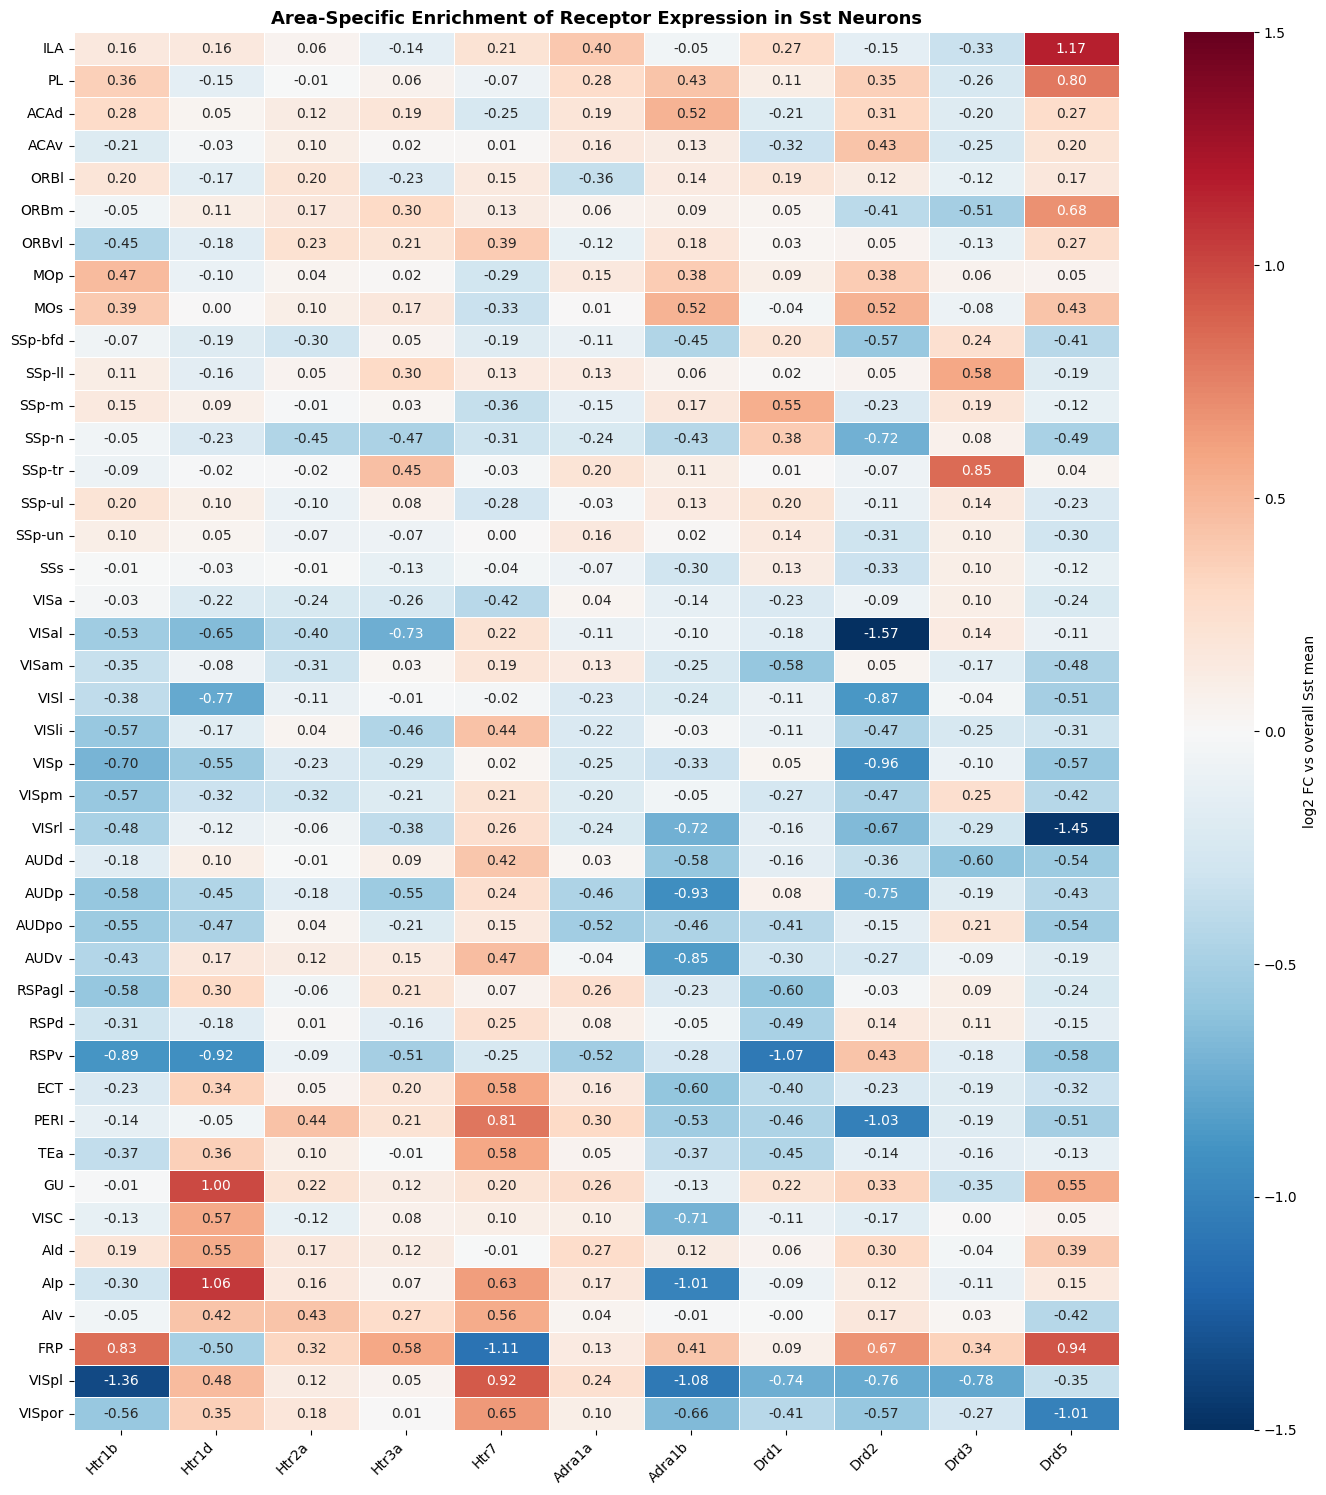

Saved: heatmap_Sst_isocortex_enrichment.png

Key area-specific enrichments (|log2FC| > 0.3):
  ILA          Adra1a  : +0.40 (enriched)
  ILA          Drd3    : -0.33 (depleted)
  ILA          Drd5    : +1.17 (enriched)
  PL           Htr1b   : +0.36 (enriched)
  PL           Adra1b  : +0.43 (enriched)
  PL           Drd2    : +0.35 (enriched)
  PL           Drd5    : +0.80 (enriched)
  ACAd         Adra1b  : +0.52 (enriched)
  ACAd         Drd2    : +0.31 (enriched)
  ACAv         Drd1    : -0.32 (depleted)
  ACAv         Drd2    : +0.43 (enriched)
  ORBl         Adra1a  : -0.36 (depleted)
  ORBm         Htr3a   : +0.30 (enriched)
  ORBm         Drd2    : -0.41 (depleted)
  ORBm         Drd3    : -0.51 (depleted)
  ORBm         Drd5    : +0.68 (enriched)
  ORBvl        Htr1b   : -0.45 (depleted)
  ORBvl        Htr7    : +0.39 (enriched)
  MOp          Htr1b   : +0.47 (enriched)
  MOp          Adra1b  : +0.38 (enriched)
  MOp          Drd2    : +0.38 (enriched)
  MOs          Htr1b   : 

In [15]:
# Log2 fold-change relative to overall Sst mean
overall_mean = expr_df[receptor_genes].mean()
pseudocount = 0.01
log2fc = np.log2((area_mean + pseudocount) / (overall_mean + pseudocount))

fig, ax = plt.subplots(figsize=(14, max(6, n_areas * 0.35)))
sns.heatmap(log2fc, annot=True, fmt='.2f', cmap='RdBu_r', center=0,
            ax=ax, linewidths=0.5, vmin=-1.5, vmax=1.5,
            cbar_kws={'label': 'log2 FC vs overall Sst mean'})
ax.set_title('Area-Specific Enrichment of Receptor Expression in Sst Neurons',
             fontweight='bold', fontsize=13)
ax.set_ylabel('')
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
plt.tight_layout()
plt.savefig('heatmap_Sst_isocortex_enrichment.png', dpi=150, bbox_inches='tight')
plt.show()
print('Saved: heatmap_Sst_isocortex_enrichment.png')

print('\nKey area-specific enrichments (|log2FC| > 0.3):')
for area in sorted_areas:
    for g in receptor_genes:
        fc = log2fc.loc[area, g]
        if abs(fc) > 0.3:
            direction = 'enriched' if fc > 0 else 'depleted'
            print(f'  {area:12s} {g:8s}: {fc:+.2f} ({direction})')

## 8. Summary Statistics

In [16]:
print('=' * 70)
print('Mean Expression (log2) — Sst Neurons by Cortical Area (MERFISH)')
print('=' * 70)
display(area_mean.round(3))

print('\n' + '=' * 70)
print('Fraction Expressing — Sst Neurons by Cortical Area (MERFISH)')
print('=' * 70)
display(area_frac.round(3))

# Save
area_mean.to_csv('sst_isocortex_area_mean_expression.csv')
area_frac.to_csv('sst_isocortex_area_frac_expressing.csv')
log2fc.to_csv('sst_isocortex_area_enrichment.csv')
print('\nSaved summary CSVs.')

Mean Expression (log2) — Sst Neurons by Cortical Area (MERFISH)


,Htr1b,Htr1d,Htr2a,Htr3a,Htr7,Adra1a,Adra1b,Drd1,Drd2,Drd3,Drd5
area,,,,,,,,,,,
ILA,0.412,0.161,1.049,0.099,0.407,0.611,0.787,0.860,0.402,0.136,0.405
PL,0.475,0.128,1.001,0.116,0.332,0.561,1.101,0.768,0.573,0.144,0.311
ACAd,0.450,0.148,1.097,0.127,0.292,0.526,1.175,0.615,0.554,0.151,0.213
ACAv,0.317,0.139,1.082,0.112,0.353,0.517,0.894,0.566,0.604,0.145,0.202
ORBl,0.424,0.126,1.160,0.093,0.388,0.356,0.901,0.812,0.485,0.159,0.198
ORBm,0.354,0.155,1.138,0.139,0.382,0.481,0.872,0.734,0.334,0.119,0.287
ORBvl,0.266,0.125,1.184,0.129,0.460,0.424,0.929,0.726,0.462,0.159,0.212
MOp,0.515,0.132,1.036,0.112,0.284,0.513,1.063,0.759,0.583,0.182,0.182
MOs,0.487,0.143,1.082,0.125,0.275,0.463,1.176,0.692,0.646,0.164,0.239



Fraction Expressing — Sst Neurons by Cortical Area (MERFISH)


,Htr1b,Htr1d,Htr2a,Htr3a,Htr7,Adra1a,Adra1b,Drd1,Drd2,Drd3,Drd5
area,,,,,,,,,,,
ILA,0.367,0.148,0.668,0.109,0.376,0.489,0.559,0.620,0.306,0.148,0.393
PL,0.383,0.129,0.658,0.122,0.304,0.464,0.698,0.554,0.383,0.162,0.298
ACAd,0.367,0.150,0.681,0.126,0.276,0.425,0.703,0.435,0.374,0.171,0.201
ACAv,0.265,0.132,0.636,0.121,0.308,0.400,0.572,0.420,0.395,0.157,0.195
ORBl,0.357,0.142,0.719,0.106,0.360,0.317,0.633,0.581,0.369,0.181,0.211
ORBm,0.321,0.151,0.694,0.145,0.330,0.414,0.623,0.522,0.269,0.151,0.275
ORBvl,0.266,0.138,0.738,0.138,0.409,0.381,0.671,0.537,0.357,0.182,0.215
MOp,0.386,0.135,0.641,0.117,0.261,0.389,0.670,0.498,0.365,0.191,0.180
MOs,0.381,0.148,0.686,0.136,0.261,0.385,0.718,0.497,0.408,0.181,0.228



Saved summary CSVs.
